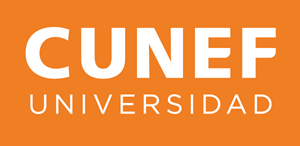

# Master en Data Science - Trabajo Final de Máster

# **3. Modelado Predictivo**
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
### DataSet: *IBM - Telco Customer Churn*

En este notebook se realizará la definición del modelado predictivo a aplicar al dataset. Para ello se realizará un 'benchmarking' de algunos de los principales modelos de machine learning específicos para clasificación, en este caso de si el cliente es propenso a la fuga o no, con el fin de determinar cuál o cuáles serán los modelos ganadores y por ende los que se utilizarán y medirán finalmente en la aplicación al set de test.

## Librerías y funciones

Sección en la que se importan las librerías públicas y también se importan funciones personalizadas desde un script propio.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import importlib
import warnings
import joblib
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

SEED=10

In [55]:
sys.path.append('../src/')
import functions_rfc_IBM as fr
importlib.reload(fr)
sys.path.remove('../src/')

## Carga del Dataset

Se procede a cargar nuevamente el dataset original y luego a aplicar los preprocesamientos definidos en el anterior notebook

In [56]:
df_train = pd.read_parquet('../data/ibm_telco_churn/df_telco_train.parquet')
display(df_train.head(), df_train.shape)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Score,CLTV,Churn Reason,Churn Value
2125,0021-IKXGC,1,United States,California,San Marcos,92078,"33.119028, -117.166036",33.119028,-117.166036,Female,Yes,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,72.10,72.10,No,50,4432,None,0
6768,1395-OFUWC,1,United States,California,Los Angeles,90067,"34.057496, -118.413959",34.057496,-118.413959,Male,No,Yes,Yes,43,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Credit card (automatic),29.30,1224.05,No,70,4741,None,0
6796,8080-POTJR,1,United States,California,Rancho Palos Verdes,90275,"33.753146, -118.367459",33.753146,-118.367459,Female,No,No,No,30,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),79.30,2427.10,No,78,2655,None,0
476,3132-TVFDZ,1,United States,California,Glendale,91202,"34.167926, -118.267539",34.167926,-118.267539,Male,Yes,Yes,No,57,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.85,2572.95,Yes,82,5172,Attitude of support person,1
6706,3898-BSJYF,1,United States,California,Herlong,96113,"40.198234, -120.18089",40.198234,-120.180890,Female,No,No,Yes,10,Yes,Yes,DSL,Yes,No,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.55,693.30,No,29,4434,None,0


(4413, 33)

Separación en X e y:

In [57]:
X = df_train.drop(columns='Churn Value', axis=1)
y = df_train['Churn Value']

X.shape, y.shape

((4413, 32), (4413,))

## Preprocesamiento

Se aplican las funciones de preprocesamiento definidas con anterioridad

##### Selección de variables:

In [25]:
fr.feature_selection?

Signature: fr.feature_selection(df, add=[])
Docstring:
----------------------------------------------------------------------------------------------------------
Función feature_selection:
----------------------------------------------------------------------------------------------------------
- Funcionamiento: Recibe un DataFrame y un opcional de columnas extras a eliminar. Devuelve un DataFrame
con las columnas del feature selection eliminadas, además de la columna extra en caso de haberse introducido.
- Inputs:
    - df: DataFrame de Pandas al que se le reducirá el número de variables
    - add: argumento opcional en el que se pueden incluir más variables que se quieran eliminar
- Return: DataFrame de pandas con las columnas reducidas según el feature selection aplicado.
File:      c:\users\rodri\onedrive\documentos\studies\master_cunef_data_science\tfm\src\functions_rfc_ibm.py
Type:      function

In [58]:
X_s = fr.feature_selection(X)
display(X_s.head(),X_s.shape)

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Contract,Paperless Billing,Payment Method,Monthly Charges,CLTV
2125,Yes,No,No,1,Yes,Fiber optic,No,No,No,No,Month-to-month,Yes,Electronic check,72.10,4432
6768,No,Yes,Yes,43,No,DSL,No,Yes,No,No,Month-to-month,No,Credit card (automatic),29.30,4741
6796,No,No,No,30,Yes,DSL,Yes,No,Yes,No,One year,Yes,Credit card (automatic),79.30,2655
476,Yes,Yes,No,57,No,DSL,No,No,No,No,Month-to-month,Yes,Electronic check,44.85,5172
6706,No,No,Yes,10,Yes,DSL,Yes,No,Yes,Yes,One year,No,Credit card (automatic),73.55,4434


(4413, 15)

Se aplica función de definición de tipos de variables y se guardan los listados de cada tipo:

In [59]:
bools, cats, nums = fr.tipos_vars(X_s)

(boolean) - Senior Citizen :  ['Yes' 'No']
(boolean) - Partner :  ['No' 'Yes']
(boolean) - Dependents :  ['No' 'Yes']
(numeric) - Tenure Months : Range = [0.00 to 72.00], Mean = 32.90
(boolean) - Phone Service :  ['Yes' 'No']
(boolean) - Internet Service :  ['Fiber optic' 'DSL']
(boolean) - Online Security :  ['No' 'Yes']
(boolean) - Online Backup :  ['No' 'Yes']
(boolean) - Device Protection :  ['No' 'Yes']
(boolean) - Tech Support :  ['No' 'Yes']
(categoric)(Type: object) - Contract : ['Month-to-month', 'One year', 'Two year']
(boolean) - Paperless Billing :  ['Yes' 'No']
(categoric)(Type: object) - Payment Method : ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
(numeric) - Monthly Charges : Range = [23.45 to 118.75], Mean = 76.86
(numeric) - CLTV : Range = [2003.00 to 6500.00], Mean = 4410.36


## Separación en set de Train y Validation

Se realiza una división en set de entrenamiento y validación, para poder medir los resultados de los modelos sin la necesidad de contaminar el set de test.

In [60]:
X_train_pre, X_val_pre, y_train, y_val = train_test_split(X_s
                                                         ,y
                                                         ,test_size=0.2
                                                         ,random_state=SEED
                                                         ,stratify=y)
X_train_pre.shape, X_val_pre.shape, y_train_pre.shape, y_val_pre.shape

((3530, 15), (883, 15), (3530,), (883,))

##### Función de preprocesamiento / transformación de variables:

Se muestra el docstring y se aplica la función de preprocesamiento:

In [29]:
fr.Preprocessing?

Signature:
fr.Preprocessing(
    df,
    cat_transf='mix',
    scale=True,
    cat_vars=None,
    num_vars=None,
    bool_vars=None,
    vars_ord=[],
    vars_oh=[],
    not_scale=[],
    nulls_strategy='median',
    show_info=False,
)
Docstring:
----------------------------------------------------------------------------------------------------------
Preprocessing function:
----------------------------------------------------------------------------------------------------------
- Description: Function that receives a dataframe and performs the preprocessing based on the parameters
            that the user chooses.
- Inputs:
    - df: dataframe to be preprocessed.
    - cat_transf: type of transformation for categorical variables. It can be 'ordinal',
    'onehot', 'mean' or 'mix'.
    - scale: boolean that indicates if the numeric variables should be scaled.
    - cat_vars: list of categorical variables to be transformed.
    - num_vars: list of numeric variables to be transformed.


In [61]:
preprocessor = fr.Preprocessing(X_train_pre,
                                cat_transf='mix',
                                scale=True,
                                cat_vars=cats,
                                num_vars=nums,
                                bool_vars=bools,
                                vars_ord=['Contract'],
                                nulls_strategy='median',
                                show_info=True,
                            )

Prprocessing pipeline defined with the following parameters:
        Mean encoding: ['Payment Method']
        Numerical transformation (scaling=True input strategy=median): ['Tenure Months' 'Monthly Charges' 'CLTV']
        Booleans encoding (ordinal 0-1): ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Paperless Billing']
        Ordinal encoding: ['Contract']
        One-Hot encoding: []


In [62]:
preprocessor.fit(X_train_pre, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 array(['Tenure Months', 'Monthly Charges', 'CLTV'], dtype='<U15')),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Contra...
                                 array(['Payment Method'], dtype='<U14')),
                                ('bool',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Senior Citizen', 'Partner', 'Dependents',
                                  'Phone Service', 'Internet Service',
                                  'Online Security', 'Online Backup',
                                  'Device Protection', 'Tech Support',
                                  'Paperless Billing'])],
                  verbose_feature_names_out=False)

Transformo los sets de train y de validation:

In [63]:
X_train = preprocessor.transform(X_train_pre)
X_val = preprocessor.transform(X_val_pre)
display(X_train.head(), X_train.shape, X_val.shape)

,Tenure Months,Monthly Charges,CLTV,Contract,Payment Method,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Paperless Billing
6684,1.232877,0.883353,0.529274,1.0,0.475594,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
6529,1.395892,1.248007,0.296335,2.0,0.475594,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
410,-1.293858,-0.076144,-1.524823,0.0,0.475594,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3053,1.599661,1.252565,0.593649,2.0,0.187373,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4350,0.988354,-0.871545,-0.218672,2.0,0.204218,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


(3530, 15)

(883, 15)

## Benchmarking de modelos predictivos

Se realiza un bucle en el cual se instancian, entrenan y se miden cada uno de los 5 modelos de clasificación elegidos. Además, se incluye un DummyClassifier, que no es más que un modelo base, en el que se mide el accuracy que se obtendría en caso de no aplicar modelo, simplemente decir que ningún cliente se fugaría.

In [40]:
%%time

classifiers = [
    DummyClassifier() # Base Model
    ,GaussianNB() # NaiveBayes
    ,LogisticRegression() # Linear Model
    ,RandomForestClassifier() # Bagging
    ,XGBClassifier() # Boosting
    ,LGBMClassifier(verbose=-1) # Boosting
    ]

results_models = pd.DataFrame()

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)
    y_pred_pipe = pipe.predict(X_val)
    print(f'\033[1m{classifier}\033[0m')
    results_model = fr.metrics_summ(y_val
                                    ,y_pred_pipe
                                    ,model_name=classifier.__class__.__name__)
    results_models = pd.concat([results_models, results_model], axis=0)
    print("____________________________________________________________________________________________")

DummyClassifier()

Accuracy: 0.68177
Balanced Accuracy: 0.50000
F2 score: 0.00000
F1 score: 0.00000
Precision: 0.00000
Recall: 0.00000

Confusion Matrix:
[[602   0]
 [281   0]]
____________________________________________________________________________________________
GaussianNB()

Accuracy: 0.72707
Balanced Accuracy: 0.73152
F2 score: 0.69574
F1 score: 0.63429
Precision: 0.55291
Recall: 0.74377

Confusion Matrix:
[[433 169]
 [ 72 209]]
____________________________________________________________________________________________
LogisticRegression()

Accuracy: 0.78143
Balanced Accuracy: 0.73059
F2 score: 0.60673
F1 score: 0.63238
Precision: 0.68033
Recall: 0.59075

Confusion Matrix:
[[524  78]
 [115 166]]
____________________________________________________________________________________________


c:\Users\rodri\anaconda3\envs\practica0\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier()

Accuracy: 0.75764
Balanced Accuracy: 0.69512
F2 score: 0.54404
F1 score: 0.57874
Precision: 0.64758
Recall: 0.52313

Confusion Matrix:
[[522  80]
 [134 147]]
____________________________________________________________________________________________
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=N

In [41]:
results_models

,Model,Accuracy,Balanced Accuracy,F2 Score,F1 Score,Precision,Recall
0,DummyClassifier,0.681767,0.500000,0.000000,0.000000,0.000000,0.000000
0,GaussianNB,0.727067,0.731521,0.695739,0.634294,0.552910,0.743772
0,LogisticRegression,0.781427,0.730590,0.606725,0.632381,0.680328,0.590747
0,RandomForestClassifier,0.757644,0.695121,0.544041,0.578740,0.647577,0.523132
0,XGBClassifier,0.755379,0.701050,0.566107,0.589354,0.632653,0.551601
0,LGBMClassifier,0.755379,0.703896,0.574545,0.593985,0.629482,0.562278


Como es posible apreciar, todos los modelos tienen métricas en general bastante similares, siendo la regresión logística la que destaca levemente sobre el resto.

En este caso, las principales métricas a tener en cuenta son el Accuracy y el Balanced Accuracy, ya que buscamos que el modelo tenga cierta precisión al predecir quien será propenso a la fuga o no.

Aunque a priori la regresión logística parece ser el mejor modelo (el clasificador de bayes tampoco está mal con su alto recall), cabe destacar que tanto los modelos de Bagging como de Boosting dependen bastante de sus hiperparámetros para aprovechar su potencial, por lo que se procede a medir a uno de ellos con una pequeña búsqueda de hiperparámetros utilizando el método de validación cruzada.

El modelo elegido en representación para dicha búsqueda es el LightGBM, probablemente el modelo más famoso y utilizado hoy en día en cuanto a Boosting se refiere, debido a su gran velocidad de procesamiento en comparación con sus pares, sin pérdida de precisión en sus predicciones.

## Búsqueda de hiperparámetros para LightGBM

Debido a que los modelos de Boosting y Bagging necesitan de una hiperparametrización para aprovechar su potencial, se realiza una búsqueda rápida del mejor de estos para comparar con la Regresión Logística

In [78]:
%%time
f2_scorer = make_scorer(fbeta_score, beta=2)

lgbm = LGBMClassifier(verbosity=-1)
param_grid = { 
    'max_depth' : [3,4,5,6]
    ,'num_leaves' : [round(2**3/1.5), round(2**4/1.5), round(2**5/1.5), round(2**6/1.5)] # La documentación de LightGBM comenta que num_leaves se relaciona con el max_depth así: (num_leaves = (2^max_depth/1.5))
    ,'min_data_in_leaf' :[200,400,600]
    ,'n_estimators ': [200,300,400]
    ,'learning_rate': [0.01, 0.02, 0.05]
    ,'lambda_l1': [0, 0.5, 1]
    ,'lambda_l2': [0, 0.5, 1]
}

scoring = {'balanced_accuracy':'balanced_accuracy', 'f2':f2_scorer,'f1':'f1','accuracy':'accuracy', 'precision':'precision', 'recall':'recall','roc_auc':'roc_auc'}

CV_rs = RandomizedSearchCV(lgbm, param_grid, cv=20, random_state=SEED, n_jobs=2, scoring=scoring, refit='balanced_accuracy')

CV_rs.fit(X_train, y_train) 
print(CV_rs.best_params_)    
print(CV_rs.best_score_)

{'num_leaves': 11, 'n_estimators ': 200, 'min_data_in_leaf': 400, 'max_depth': 3, 'learning_rate': 0.05, 'lambda_l2': 0.5, 'lambda_l1': 0}
0.7303971188301333
CPU times: total: 172 ms
Wall time: 4.69 s


In [79]:
lgbm = LGBMClassifier(verbose=-1
                      ,max_depth=3
                      ,min_data_in_leaf=400
                      ,n_estimators=200
                      ,num_leaves=11
                      ,learning_rate=0.05
                      ,random_state=SEED
                      ,lambda_l2=0.5
                     )

lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_val)

fr.metrics_summ(y_val, y_pred_lgbm)


Accuracy: 0.77803
Balanced Accuracy: 0.72905
F2 score: 0.60816
F1 score: 0.63019
Precision: 0.67068
Recall: 0.59431

Confusion Matrix:
[[520  82]
 [114 167]]


,Model,Accuracy,Balanced Accuracy,F2 Score,F1 Score,Precision,Recall
0,Model,0.778029,0.729047,0.608157,0.630189,0.670683,0.594306


Vemos como en este caso el modelo mejora hasta alcanzar valores prácticamente idénticos a la regresión logística.

Estos resultados tan parejos entre ambos modelos nos permiten realizar un doble modelado, en el que, además, se suma a lo que será el análisis de que tan bien se conjuntarán los modelos paramétricos y no-paramétricos con los modelos de análisis causal, originalmente muy relacionados a la regresión lineal y logística, pero actualmente capaces de aprovechar de todo tipo de modelos para potenciar sus resultados.

Se procede además a guardar el objeto con la búsqueda de hiperparámetros del LightGBM, el cual será utilizado nuevamente en el notebook 05:

In [51]:
# Guardo el CV con joblib:
joblib.dump(CV_rs, '../models/CV_rs_lgbm_IBM.joblib')

['../models/CV_rs_lgbm_IBM.joblib']

En el siguiente notebook se introduce el modelo causal a este proceso de desarrollo.